# Sentiment Analysis

In this notebook, I aim to build and test a sentiment analysis model for tweets using the following machine-learning algorithms.

1. Logistic Regression
2. Support Vector Machines (Linear Kernel)
3. Naive Bayes

I am using the [Sentiment140 dataset with 1.6 million tweets](https://www.kaggle.com/datasets/kazanova/sentiment140?resource=download)

## Import Necessary Dependencies
The first step is importing all the required libraries

In [2]:
# utilities
import re
import numpy as np
import pandas as pd
import string
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/Anushka/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Anushka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Anushka/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Read and Load the Dataset

The dataset is in the following format

    target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

    ids: The id of the tweet ( 2087)

    date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

    flag: The query (lyx). If there is no query, then this value is NO_QUERY.

    user: the user that tweeted (robotickilldozr)

    text: the text of the tweet (Lyx is cool)


Since the csv file does not contain a header we will create a header list based on the above information. Additionally, to resolve encoding discrepancy we will specify the encoding as "ISO-8859-1". For more information on encoding visit [link](https://saturncloud.io/blog/how-to-fix-the-pandas-unicodedecodeerror-utf8-codec-cant-decode-bytes-in-position-01-invalid-continuation-byte-error/)

In [3]:
### Creating header as a list
header = ['target','ids','date','flag','user','text']

### Reading .csv file 
df =  pd.read_csv("./training.1600000.processed.noemoticon.csv", encoding='ISO-8859-1',names=header)

In [4]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Exploratory Data Analysis

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [139]:
df.isna().values.any().sum()

0

There are no null values pressent in our dataframe, yayy!!

In [127]:
df.shape

(1600000, 6)

In [47]:
df['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

We have equal count of positive and negative tweets

In [49]:
df['flag'].value_counts()

flag
NO_QUERY    1600000
Name: count, dtype: int64

Flag column has just one value so it is irrelevant for our goal. Additionally, tweet id, date of tweet and user id will not be required to detecting the sentiment of the tweet so we will drop these column and only focus on the `target` and the `text` column.

In [5]:
data = df[['target','text']]

In [143]:
data.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


## Data Visualization

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

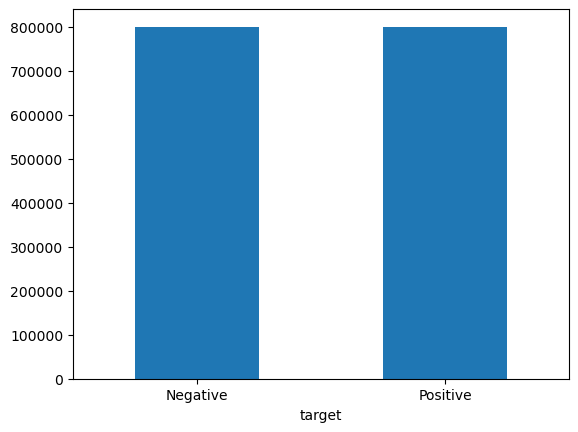

In [8]:
### Plotting the distribution for dataset.
plot = data['target'].value_counts().plot(kind ='bar')
plot.set_xticklabels(['Negative','Positive'], rotation=0)

## Splitting data

We will split the data into a training set, testing set, and validation set. This will enable us to improve the text vectorization and tune the hyperparameters of the best-performing model.  

In [6]:
### Shuffling the data to ensure proportional split of positive and negative tweets
shuffle_data = data.sample(frac=1)

In [7]:
### Splitting the dependent and independent variable
X = shuffle_data['text']
y = shuffle_data['target']

In [8]:
### Creating training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.9,random_state=42)

In [9]:
print(X_train.shape, y_train.shape)

(1440000,) (1440000,)


In [10]:
### Further splitting the training data into training and validation dataset
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, train_size=0.8, random_state=42)

In [11]:
print(X_train.shape, y_train.shape)

(1152000,) (1152000,)


## Data Preprocessing

In this step we will mainly deal with cleaning the tweets. This includes removing stop words, emojis, URLs, hashtags, mentions, and punctuations. Additionally we will stem the tweets to change the words to their root form.

In [318]:
X_train.tail(10)

214030     They should make a converter/adapter that make...
1261999    @madlyv sounds like one powerpacked juice. I a...
514367     Upset chris saying me being lovely Dovely Is a...
785741     @One_StepCloser oh ok :] i have flu and probab...
609248     @brizanizz  tell them you're ill and it's your...
1302335                 hey twitterland.. this girl is back 
1153284    it's five in the morning and i'm sitting on my...
362431                                    You make me worry 
498839              so sick of the shitty weather in Sydney 
1037831                          @SophieFumbles Yes you are 
Name: text, dtype: object

In [314]:
print("TEXT 1:" ,X_train.loc[0],"\n","TEXT 2:", X_train.loc[1])

TEXT 1: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D 
 TEXT 2: is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!


In [12]:
stop_words = set(stopwords.words('english'))

### Adding more combinations of stop words to enhance the cleaning process
setx = []
for i in stop_words:
    if len(i)<=2:
        setx.append("'"+i)
print(setx)

stop_words.update(setx)
print(stop_words)

["'up", "'by", "'ll", "'s", "'ma", "'is", "'in", "'on", "'he", "'to", "'if", "'a", "'do", "'be", "'at", "'as", "'t", "'so", "'d", "'of", "'i", "'an", "'ve", "'it", "'am", "'no", "'m", "'o", "'we", "'or", "'y", "'my", "'me", "'re"]
{'weren', 'they', "she's", 'theirs', 'up', 'there', "'we", 'myself', "'in", "'be", 'themselves', 'by', "'my", 'll', 'with', 's', 'won', 'mightn', 'each', 'ma', 'same', "you've", 'more', "'by", 'is', "'it", 'have', 'them', "hadn't", 'ain', 'hers', 'doing', 'itself', 'in', 'on', 'he', 'which', 'where', "'me", 'what', 'had', 'over', "'if", 'to', 'were', 'if', 'yourself', 'a', 'do', "'or", 'been', 'only', "needn't", 'his', 'who', 'be', 'few', "'as", "didn't", 'at', "'up", 'and', 'doesn', "you'd", 'but', "mightn't", "'at", 'herself', 'once', 'she', "wouldn't", 'during', 'as', "doesn't", "wasn't", 'because', "isn't", "it's", 'him', 'then', 'those', 't', "'am", 'for', 'has', 'off', 'so', 'until', 'couldn', 'd', "'a", 'into', 'further', 'above', 'hasn', 'again', "'i"

In [13]:
### Defining emoji patterns to be removed from the text
stemmer = nltk.PorterStemmer()
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)# symbols & pictographs
        "]+", flags=re.UNICODE)

### a comprehensive function to perform all cleaning task in one step.
def clean_tweets(txt):
    ### Tokenize the tweet
    word_tokens = word_tokenize(str(txt))
    ### Remove stop words
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    ### stem words to the base form
    stemmed_word = [stemmer.stem(w) for w in filtered_sentence]
    txt = " ".join(stemmed_word)
    ### Removing endline
    txt = txt.replace('\n','')
    ### Removing digits from tweets
    txt = re.sub(r"\d", "", txt)
    ### Removing mentions
    txt = re.sub("@[A-Za-z0-9_]+","", txt)
    ### Removing hashtags
    txt = re.sub("#[A-Za-z0-9_]+","", txt)
    ### Removing links
    txt = re.sub(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)", '',txt, flags=re.MULTILINE)
    ### Removing emojis
    txt = emoji_pattern.sub(r'',txt)
    ### Removing punctuation from the tweet
    no_punc = [char for char in txt if char not in string.punctuation]
    txt = ''.join(no_punc)
    return txt

In [14]:
### passing all the tweets from train, validation, and test set through the cleaning function
X_train = X_train.apply(clean_tweets)
X_val = X_val.apply(clean_tweets)
X_test = X_test.apply(clean_tweets)

In [15]:
cp = X_train.copy()

In [38]:
X_train.head(10)

1159014         davidguison thought go  haha  aww take care 
1104453        omg  luv show  hope everyon fun   asylm thing
747413      geniechiefett yup wotsit  though  pretti much...
875218                                   touchcream hï¿½hï¿½
5065                                               need food
992403      dannywood u left ship  amp  get say good bye ...
482025              set max obsess no  third time screen ipl
1021153                                  rain friday bore   
1276202    stare someon eye sleep  amp  wonder   quot   p...
1357125                 keepnoiselow makin want listen song 
Name: text, dtype: object

## Vector Transformation

Using TF-IDF we will convert the text into the form of vector for using them with our ML models.

In [35]:
### Initializing TF-IDF vectorizer
vectoriser = TfidfVectorizer()

### Fitting the vector to training dataset
vectoriser.fit(X_train)

TfidfVectorizer()

In [36]:
### Transforming the train, val, and test data set with the vectorizer
X_train_v = vectoriser.transform(X_train)
X_val_v = vectoriser.transform(X_val)

## Model Building and Evaluation

We will be using three different models for this problem statement.

    Bernoulli Naive Bayes Classifier
    SVM (Support Vector Machine)
    Logistic Regression

The idea behind choosing these models is that we want to try all the classifiers on the dataset ranging from simple ones to complex models, and then try to find out the one that gives the best performance among them

After training the model, we then apply the evaluation measures to check how the model is performing. Accordingly, we use the following evaluation parameters to check the performance of the models respectively:

    Accuracy Score
    Confusion Matrix with Plot


In [42]:
def model_Evaluate(model,X_t,y_t):
# Predict values for Test dataset
    y_pred = model.predict(X_t)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_t, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_t, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'mako',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### A. Bernoulli Naive Bayes Classifier

              precision    recall  f1-score   support

           0       0.76      0.79      0.78    144154
           4       0.78      0.75      0.77    143846

    accuracy                           0.77    288000
   macro avg       0.77      0.77      0.77    288000
weighted avg       0.77      0.77      0.77    288000



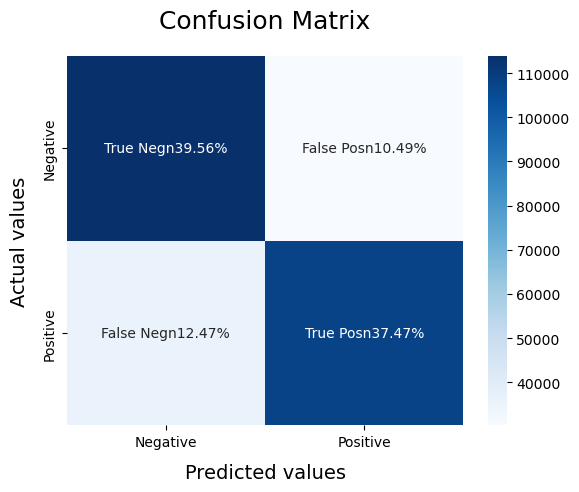

In [471]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train_v, y_train)
model_Evaluate(BNBmodel,X_val_v,y_val)

### B. SVM (Support Vector Machine)

              precision    recall  f1-score   support

           0       0.78      0.76      0.77    144154
           4       0.77      0.78      0.78    143846

    accuracy                           0.77    288000
   macro avg       0.77      0.77      0.77    288000
weighted avg       0.77      0.77      0.77    288000



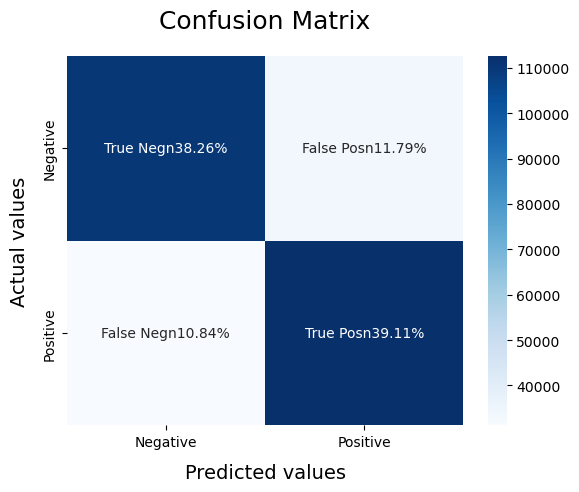

In [472]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train_v, y_train)
model_Evaluate(SVCmodel,X_val_v,y_val)

### C. Logistic Regression

              precision    recall  f1-score   support

           0       0.79      0.76      0.78    143815
           4       0.77      0.80      0.79    144185

    accuracy                           0.78    288000
   macro avg       0.78      0.78      0.78    288000
weighted avg       0.78      0.78      0.78    288000



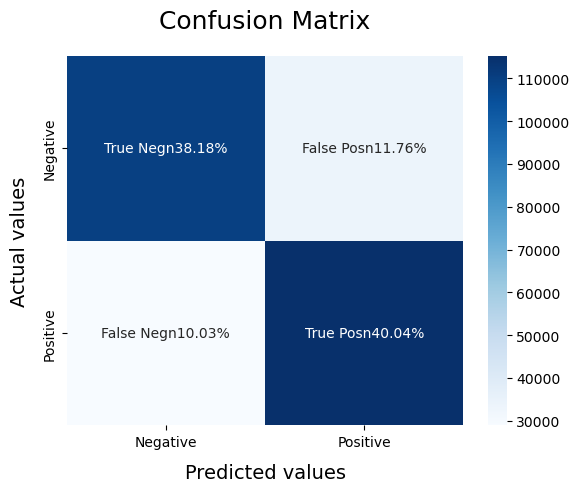

In [43]:
# LRmodel = LogisticRegression()
# LRmodel.fit(X_train_v, y_train)
model_Evaluate(LRmodel,X_val_v,y_val)

Based on the performance of the above three models it is evident that the simple logistic regression model performs slightly better than the BernoulliNB and SVM.

We will further use Logistic Regression model for improving it's accuracy and test it with the test set.

### HyperParameter Tuning

Till now all the standard parameters were employed in vectorisation and modelling steps. To improve the mode's accuracy I will utilise the hyperparameter tuning feature to find the best parameters for the TF-IDF vectorizer and Logistic regression model.

I have created a pipeline with vectorizer and model to simultaneously test the various combination of parameters to figure out the best set. 

In [19]:
### Define the pipeline
LRpipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', LogisticRegression())])

### Define the parameter grid
LRparameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2)], ## (1,3) is slow
    'model__penalty':['l2'],
    'model__C' : [100, 10, 1.0, 0.1, 0.01],
    'model__solver': ['lbfgs','liblinear'],
    'model__max_iter'  : [1000]
}

### Setting up and fitting the Randomized search
LR_rand_search = RandomizedSearchCV(LRpipeline, LRparameters, cv=2, n_iter= 20, verbose=3, scoring = "accuracy", n_jobs=-1,error_score=0)
LR_rand_search.fit(X_train, y_train)

### Printing the output of best parameter
print("Best parameters set:")
print (LR_rand_search.best_estimator_.steps)


Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV 2/2] END model__C=10, model__max_iter=1000, model__penalty=l2, model__solver=lbfgs, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2);, score=0.789 total time=24.0min
Best parameters set:
[('tfidf', TfidfVectorizer(max_df=0.25, ngram_range=(1, 2))), ('model', LogisticRegression(max_iter=1000, solver='liblinear'))]
[CV 2/2] END model__C=0.01, model__max_iter=1000, model__penalty=l2, model__solver=lbfgs, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1);, score=0.750 total time=  13.7s
[CV 2/2] END model__C=100, model__max_iter=1000, model__penalty=l2, model__solver=lbfgs, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1);, score=0.758 total time= 1.5min
[CV 2/2] END model__C=1.0, model__max_iter=1000, model__penalty=l2, model__solver=lbfgs, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2);, score=0.791 total time=16.5min
[CV 1/2] END model__C=1.0, model__max_iter=1000, model__penalty=l2, model__solver=lbfgs, tfidf__max_df=0.75, tfidf__ngr

In [20]:
LR_rand_search.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.25, ngram_range=(1, 2))),
                ('model',
                 LogisticRegression(max_iter=1000, solver='liblinear'))])

In [24]:
### Displaying the various metrics and it's accuracy in dataframe
pd.DataFrame(LR_rand_search.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tfidf__ngram_range,param_tfidf__max_df,param_model__solver,param_model__penalty,param_model__max_iter,param_model__C,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,113.108018,6.418752,31.006024,2.942512,"(1, 2)",0.25,liblinear,l2,1000,1.0,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_df'...",0.791630,0.790503,0.791067,0.000563,1
8,62.622688,4.302421,29.496332,1.969556,"(1, 2)",0.75,liblinear,l2,1000,1.0,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_df'...",0.791630,0.790503,0.791067,0.000563,1
6,648.816112,308.815853,32.045296,2.425174,"(1, 2)",0.50,lbfgs,l2,1000,1.0,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_df'...",0.791165,0.790799,0.790982,0.000183,3
18,230.744928,24.459732,32.749118,8.952244,"(1, 2)",0.75,lbfgs,l2,1000,1.0,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_df'...",0.791165,0.790799,0.790982,0.000183,3
13,101.088875,1.125440,43.149328,1.728687,"(1, 2)",0.25,liblinear,l2,1000,10.0,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_df'...",0.790512,0.789519,0.790016,0.000497,5


The two parameter set at rank one have the same score but different time. We will choose the parameter set which takes less amount of time. That is take 

`max_df = .75`

In [29]:
### Initializing custom TF-IDF vectorizer
vectoriser_custom = TfidfVectorizer(max_df=0.75,ngram_range=(1,2))

### Fitting the custom vector to training dataset
vectoriser_custom.fit(X_train)

TfidfVectorizer(max_df=0.75, ngram_range=(1, 2))

In [30]:
### Transforming the train, and test data set with the custom vectorizer
X_train_cv = vectoriser_custom.transform(X_train)
X_test_cv = vectoriser_custom.transform(X_test)

              precision    recall  f1-score   support

           0       0.80      0.79      0.80     79827
           4       0.79      0.80      0.80     80173

    accuracy                           0.80    160000
   macro avg       0.80      0.80      0.80    160000
weighted avg       0.80      0.80      0.80    160000



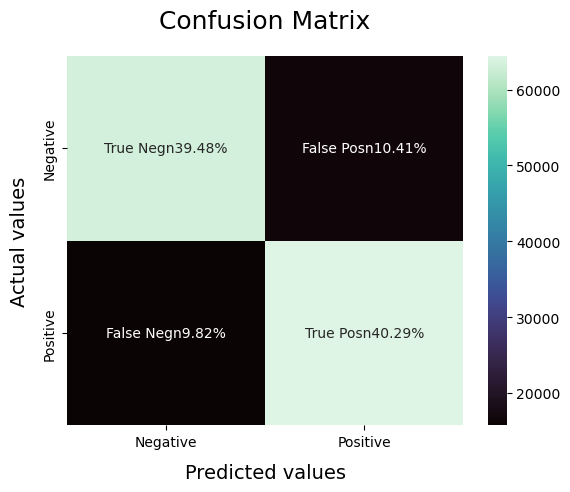

In [34]:
### Training and testing the custom Logistic model
LRmodel_custom = LogisticRegression(C = 1, max_iter = 1000, penalty = 'l2', solver='liblinear')
LRmodel_custom.fit(X_train_cv, y_train)
model_Evaluate(LRmodel_custom,X_test_cv,y_test)